In [1]:
#Logan Kelsch + JJ
'''
/*
 *  taking this version of neural network training takes only a few features
 *          [ high, low, open, close, volume, TimeOfDay, DayOfWeek ]
 *  and uses common techniques described in 'features_creation.py' to largely
 *  expand dimensionality. 
 *  As of writing this (11/24/24) there is limited expansion
*/
''' 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from funcs_data_process import *
from feature_creation import *
from performance_printout import *
from tensorflow.keras.optimizers import AdamW


# Load the dataset
data = pd.read_csv('betaset_tmp.csv')

'''#---------------#
    MODEL VARIABLES
'''#---------------#


indp_size       = 0.05       #size of indepentendent set of samples
test_size       = 0.15       #size of validation set of samples
num_isol_feats  = 0         #number of features to be left out of PCA transformation
                            #   this function is depricated/needs updated
use_PCA         = False      #bool for use of PCA feature decomp. and transformation
comps_PCA       = 128        #number of primary components to use under PCA t.

time_steps      = 5        #LSTM time steps used

t_start         = 570       #start time for time based sample filtering         570 is 9:30am EST
t_end           = 720       #end   time for time based sample filtering         645,720 are 10:45am,12:00pm EST

params = model_params()
params = get_model_params(
    m_type          = 'Classification'      # {'Regression', 'Classification'}

   ,target_time     = 15        #how many minutes in the future is the target
   ,c_split_val     = 5
   ,c_class_cnt     = 2
)


#drop unused target columns
data = set_target(data, params)

#collect all sample indices to be kept through time filter
#two seperate functions to keep main and ind test isolated
keep_ndx = grab_wanted_times(data.values, t_start, t_end, time_steps)

data = data.drop(columns=return_name_collection())
#data = data.drop(columns=fn_orig_time())

#confirmation printout of all features/targets
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)


# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

params = update_class_weights(y, params)

if(params.model_type=='Classification'):
    y, label_encoder = y_preprocess(params, y)

X_nrm = normalize_from_tt_split(X, X, test_size)
if(use_PCA):
    X = reform_with_PCA_isolated(X_nrm, X_nrm, test_size, num_isol_feats, comps_PCA)
#X, y = reformat_to_lstm(X, y, time_steps)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))


print(f'Raw Sample Count:\t{len(X)}')
X,     y     = filter_times(X,     y,     keep_ndx)
print(f'Remaining Sample Count:\t{len(X)}')

#split all samples 3 ways into training, and testing
#   and split all testing into validation and independent
X_train, X_val, X_ind, y_train, y_val, y_ind =\
    split_into_train_val_ind(X, y, test_size, indp_size, time_steps)

if(params.model_type=='Classification'):
    inv_trn_y = label_encoder.inverse_transform(y_train)
    params = update_class_weights(inv_trn_y, params)

print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_val shape == {}.'.format(X_val.shape))
print('y_val shape == {}.'.format(y_val.shape))
print('X_ind shape == {}.'.format(X_ind.shape))
print('y_ind shape == {}.\n'.format(y_ind.shape))



2024-12-13 20:54:39.749103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 20:54:39.761094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734141279.774868  206113 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734141279.778278  206113 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 20:54:39.791625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TARGET: tc_2c_15m
TESTED FEATURES: 
Index(['volume', 'time', 'ToD', 'DoW', 'vel1', 'vel2', 'vel3', 'vel4', 'vel5',
       'vel6',
       ...
       'hilo_stoch_120_30', 'hilo_stoch_120_60', 'hilo_stoch_120_120',
       'hilo_stoch_120_240', 'hilo_stoch_240_5', 'hilo_stoch_240_15',
       'hilo_stoch_240_30', 'hilo_stoch_240_60', 'hilo_stoch_240_120',
       'hilo_stoch_240_240'],
      dtype='object', length=436)
TESTING FOR: 
tc_2c_15m

X shape == (226576, 436).
y shape == (226576, 1).

Raw Sample Count:	226576
Remaining Sample Count:	24943

X_train shape == (19954, 436).
y_train shape == (19954,).
X_val shape == (3736, 436).
y_val shape == (3736,).
X_ind shape == (1243, 436).
y_ind shape == (1243,).



In [6]:
'''
    Here is the cool area of code, gonna try as many aeon things as possible to see what we can do
'''
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
def new_dt(max_depth):
    if(params.model_type=='Regression'):
        return DecisionTreeRegressor(max_depth=max_depth)
    else:
        return DecisionTreeClassifier(max_depth=max_depth)

dt = new_dt(2)

#   CONVOLUTION BASED
from aeon.regression.convolution_based import HydraRegressor
from aeon.regression.convolution_based import MultiRocketHydraRegressor
from aeon.regression.convolution_based import RocketRegressor
from aeon.regression.convolution_based import MiniRocketRegressor
from aeon.regression.convolution_based import MultiRocketRegressor
#   DISTANCE BASED
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
#   INTERVAL BASED
from aeon.regression.interval_based import TimeSeriesForestRegressor
from aeon.classification.interval_based import TimeSeriesForestClassifier
from aeon.classification.sklearn import RotationForestClassifier
#   DEEPLEARNING BASED
from aeon.classification.deep_learning import InceptionTimeClassifier
#   SHAPELET BASED
from aeon.classification.shapelet_based import ShapeletTransformClassifier

from sklearn.ensemble import AdaBoostClassifier

model1 = HydraRegressor(n_kernels=8, n_groups=16, random_state=42)#n_jobs=-1, random_state=None)
model2 = MultiRocketHydraRegressor(n_kernels= 2, n_groups=2, random_state=42) #NOTE# CANNOT WORK ON 16GB OF MEMORY END#NOTE#
model3 = RocketRegressor(n_kernels=2048, estimator=None, n_jobs=-1)
model4 = MiniRocketRegressor(n_kernels=512, max_dilations_per_kernel=16, n_jobs=-1)
model5 = MultiRocketRegressor(n_kernels=4, max_dilations_per_kernel=2, n_features_per_kernel=32, n_jobs=-1)

#jesus lord almight this thing is crazy, cannot balance classes, but like if that
#becomes possible for this then this is first up. sticks to heavier class :(
model10c = InceptionTimeClassifier()
model16 = KNeighborsTimeSeriesRegressor(n_neighbors=16, distance='euclidean', n_jobs=-1)
model26 = TimeSeriesForestRegressor(base_estimator=new_dt(max_depth=9),n_estimators=4, random_state=42, min_interval_length=1, max_interval_length=20, contract_max_n_estimators=1, n_jobs=-1)
model26c = TimeSeriesForestClassifier(base_estimator=new_dt(max_depth=5),n_estimators=16, random_state=42, min_interval_length=1, max_interval_length=20, contract_max_n_estimators=1, n_jobs=-1)

#56%accuracy with these stats
model33c = RotationForestClassifier(base_estimator=new_dt(max_depth=4),
                                    n_estimators=5
                                    ,min_group=13
                                    ,max_group=16
                                    ,remove_proportion= 0.3
                                    ,contract_max_n_estimators=500
                                    ,random_state=42,n_jobs=-1)

model31c = ShapeletTransformClassifier(n_shapelet_samples=5
                                       ,max_shapelets=None
                                       ,max_shapelet_length=None
                                       ,estimator=new_dt(max_depth=2)
                                       ,batch_size=500
                                       ,random_state=0
                                       ,n_jobs=-1)

model = model33c

value: 0.1..0.2..0.30000000000000004..0.4..0.5..0.6..0.7000000000000001..0.8..0.9..

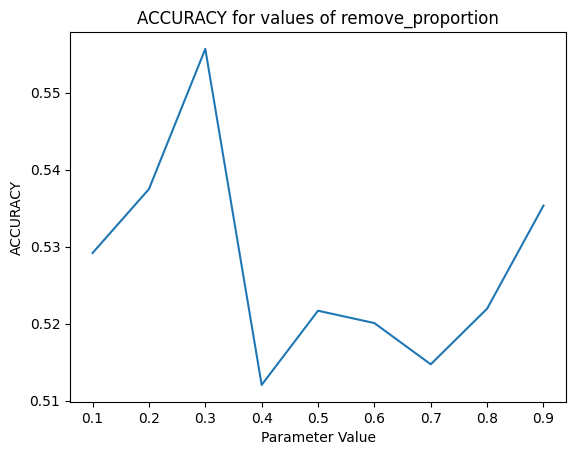

In [9]:
param_score_search(model=model,
                   params=params,
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_val,
                   y_test=y_val,
                   dynamic_param_name=  'remove_proportion'
                   ,val_range=          np.arange(0.1, 1, 0.1))

In [7]:
model.fit(X_train, y_train)

RotationForestClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                         max_group=16, min_group=13, n_estimators=5, n_jobs=-1,
                         random_state=42, remove_proportion=0.3)

Training ACCURACY:
	0.5970732685175905
Validation ACCURACY: 0.5556745182012848
Independent ACCURACY: 0.5615446500402252
Combined Test ACCURACY:
	0.5571420511610199


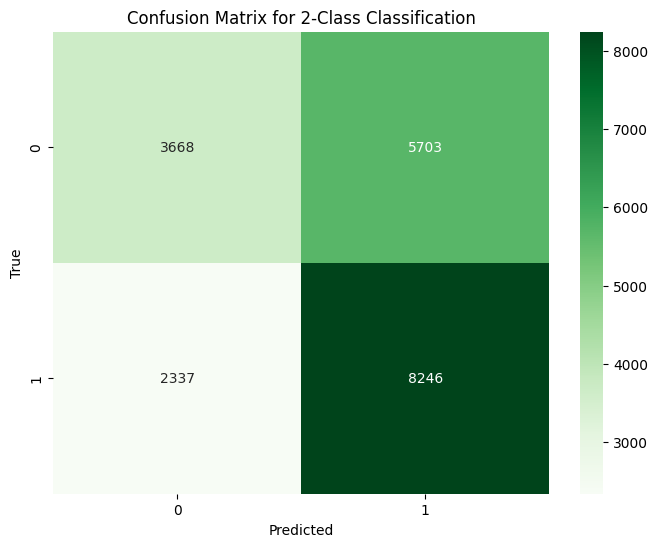

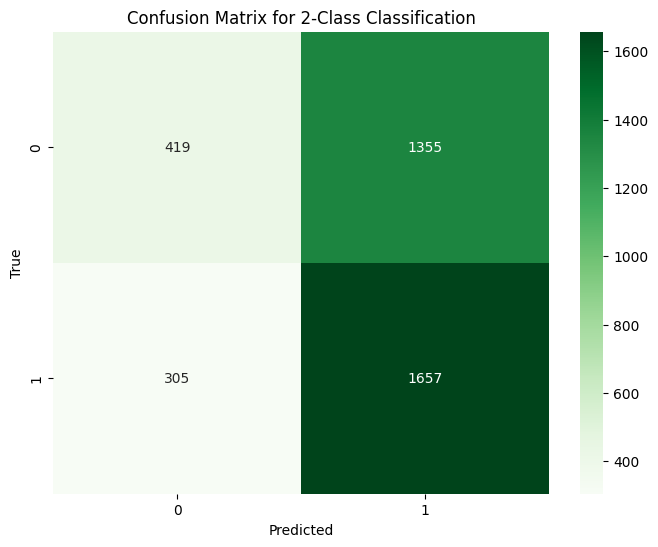

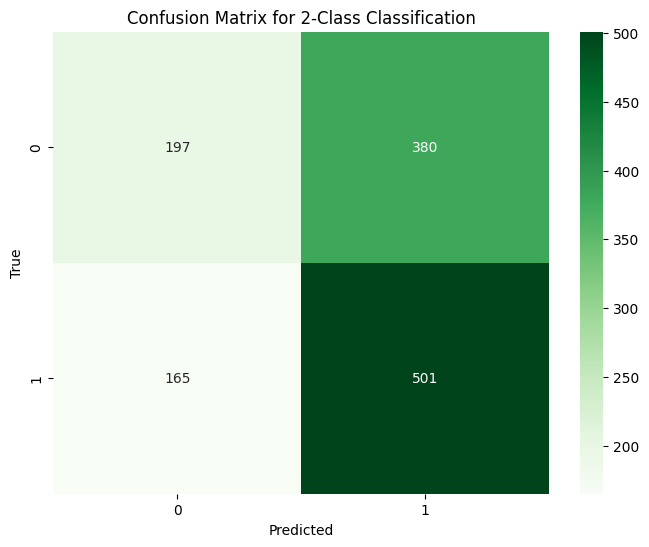

In [8]:
cl = True if params.model_type=='Classification' else False
#only relevant to classifcation models
t = 0.5
#predict training set
y_pred_train = model.predict(X_train)
#predict validation set
y_pred_val = model.predict(X_val)
#predict independent set
y_pred_ind = model.predict(X_ind)
#combine testing score
score_type, score_train = score_model(y_train, y_pred_train, t, params)
score_type, score_val = score_model(y_val, y_pred_val, t, params)
score_type, score_ind = score_model(y_ind, y_pred_ind, t, params)
score_test = (score_val*3+score_ind)/4
print(f'Training {score_type}:\n\t{score_train}')
print(f'Validation {score_type}: {score_val}')
print(f'Independent {score_type}: {score_ind}')
print(f'Combined Test {score_type}:\n\t{score_test}')

graph_predictions(y_pred_train, y_train, params, 'Training')
graph_predictions(y_pred_val, y_val, params, 'validation')
graph_predictions(y_pred_ind, y_ind, params, 'independent')

In [13]:
import pickle

filename = 'RotationForestClassifier_model1_pcaNOTIMES.sav'

pickle.dump(model, open(filename, 'wb'))
pickle.load(open(filename, 'rb'))

In [1]:
import torch
print(torch.backends.cudnn.version())

90600
